In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


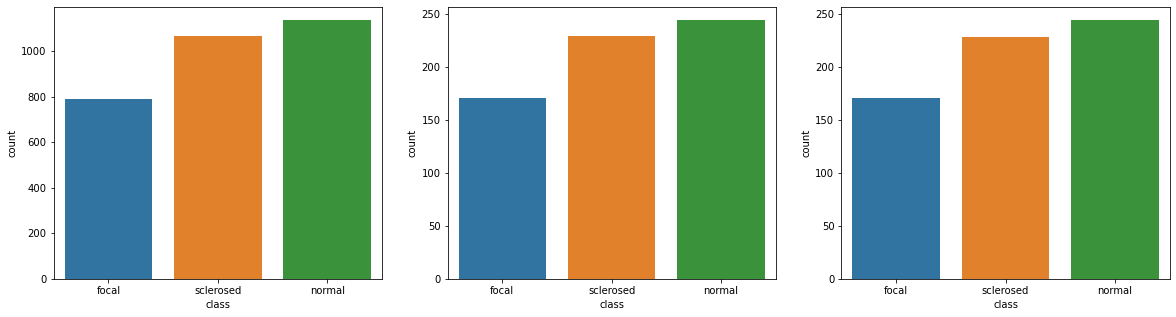

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
category_num=3
BUFFER_SIZE = len(train_folders)
IMG_SIZE = 150

In [4]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
test_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        shuffle=BUFFER_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  shuffle=BUFFER_SIZE,
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      shuffle=BUFFER_SIZE,
                                                      batch_size=BATCH_SIZE, 
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


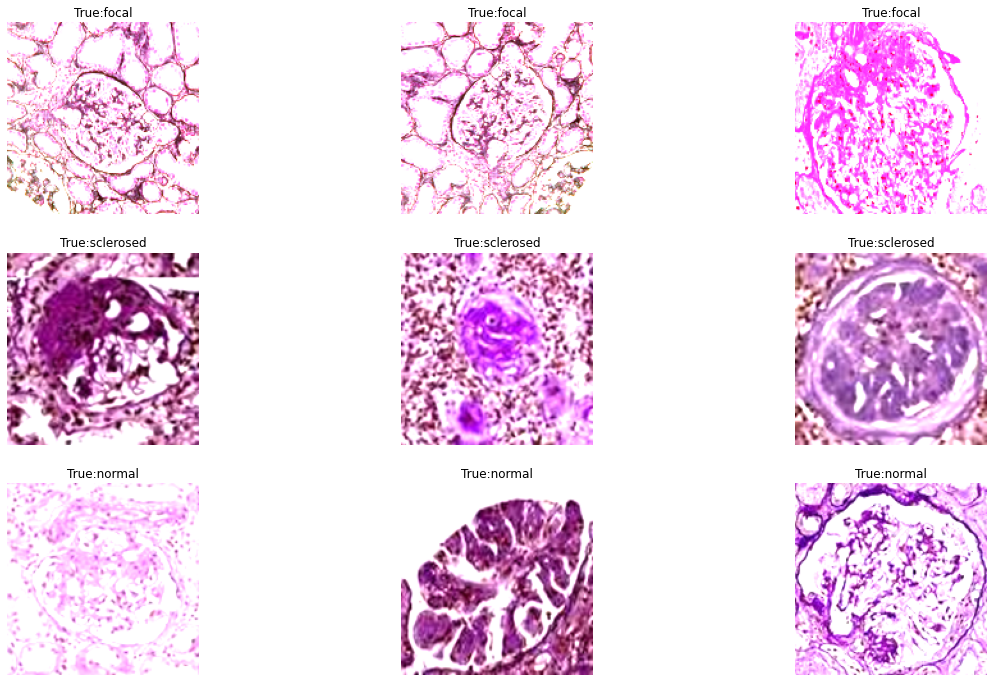

In [9]:
show_few_images(3,None)

In [10]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [11]:
with strategy.scope():
    model = tf.keras.applications.VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
                layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(1)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:local

[0.3923228681087494, 0.9051321744918823]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(2)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
1497/1497 [==============================] - 28s 11ms/step - loss: 0.0274 - acc: 0.9913 - val_loss: 0.3010 - val_acc: 0.9237
Epoch 2/30
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0234 - acc: 0.9933 - val_loss: 0.4212 - val_acc: 0.8941
Epoch 3/30
1497/1497 [==============================] - 24s 16ms/step - loss: 0.0252 - acc: 0.9903 - val_loss: 0.3586 - val_acc: 0.9237
Epoch 4/30
1497/1497 [==============================] - 23s 16ms/step - loss: 0.0196 - acc: 0.9937 - val_loss: 0.3114 - val_acc: 0.9206
Epoch 5/30
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0199 - acc: 0.9933 - val_loss: 0.3294 - val_acc: 0.9268
Epoch 6/30
1497/1497 [==============================] - 23s 15ms/step - loss: 0.0166 - acc: 0.9940 - val_loss: 0.3234 - val_acc: 0.9174
Epoch 7/30
1497/1497 [==============================] - 18s 12ms/step - loss: 0.0186 - acc: 0.9940 - 

[0.5065521001815796, 0.9097978472709656]

In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(4)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
749/749 [==============================] - 38s 21ms/step - loss: 0.0023 - acc: 0.9997 - val_loss: 0.4281 - val_acc: 0.9128
Epoch 2/30
749/749 [==============================] - 11s 14ms/step - loss: 0.0020 - acc: 0.9997 - val_loss: 0.3942 - val_acc: 0.9299
Epoch 3/30
749/749 [==============================] - 11s 15ms/step - loss: 0.0046 - acc: 0.9990 - val_loss: 0.4389 - val_acc: 0.9159
Epoch 4/30
749/749 [==============================] - 11s 15ms/step - loss: 0.0279 - acc: 0.9906 - val_loss: 0.3888 - val_acc: 0.9237
Epoch 5/30
749/749 [==============================] - 16s 21ms/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.3764 - val_acc: 0.9283
Epoch 6/30
749/749 [==============================] - 11s 14ms/step - loss: 0.0025 - acc: 0.9993 - val_loss: 0.3958 - val_acc: 0.9237
Epoch 7/30
749/749 [==============================] - 11s 15ms/step - loss: 0.0022 - acc: 0.9993 - val_loss: 0.40

[0.4887365996837616, 0.9160186648368835]

In [15]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(8)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
375/375 [==============================] - 35s 31ms/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.4703 - val_acc: 0.9174
Epoch 2/30
375/375 [==============================] - 12s 31ms/step - loss: 4.2324e-04 - acc: 0.9997 - val_loss: 0.4709 - val_acc: 0.9237
Epoch 3/30
375/375 [==============================] - 12s 31ms/step - loss: 8.5638e-04 - acc: 0.9993 - val_loss: 0.4603 - val_acc: 0.9221
Epoch 4/30
375/375 [==============================] - 7s 18ms/step - loss: 6.9218e-04 - acc: 0.9997 - val_loss: 0.4444 - val_acc: 0.9221
Epoch 5/30
375/375 [==============================] - 11s 30ms/step - loss: 9.2852e-04 - acc: 0.9997 - val_loss: 0.4737 - val_acc: 0.9190
Epoch 6/30
375/375 [==============================] - 12s 31ms/step - loss: 0.0010 - acc: 0.9997 - val_loss: 0.4829 - val_acc: 0.9112
Epoch 7/30
375/375 [==============================] - 12s 32ms/step - loss: 0.0012 - acc: 0.9997 -

[0.55165034532547, 0.9066873788833618]

In [16]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(16)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
188/188 [==============================] - 30s 28ms/step - loss: 2.5210e-04 - acc: 1.0000 - val_loss: 0.5015 - val_acc: 0.9190
Epoch 2/30
188/188 [==============================] - 5s 27ms/step - loss: 2.0490e-04 - acc: 1.0000 - val_loss: 0.4981 - val_acc: 0.9206
Epoch 3/30
188/188 [==============================] - 10s 53ms/step - loss: 1.8633e-04 - acc: 1.0000 - val_loss: 0.4994 - val_acc: 0.9221
Epoch 4/30
188/188 [==============================] - 5s 26ms/step - loss: 1.7160e-04 - acc: 1.0000 - val_loss: 0.4995 - val_acc: 0.9221
Epoch 5/30
188/188 [==============================] - 6s 30ms/step - loss: 1.5641e-04 - acc: 1.0000 - val_loss: 0.5006 - val_acc: 0.9221
Epoch 6/30
188/188 [==============================] - 6s 30ms/step - loss: 1.5232e-04 - acc: 1.0000 - val_loss: 0.5009 - val_acc: 0.9221
Epoch 7/30
188/188 [==============================] - 5s 28ms/step - loss: 1.3991e-04 - acc: 

[0.566260814666748, 0.9129082560539246]

In [17]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(32)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
94/94 [==============================] - 43s 189ms/step - loss: 4.2622e-05 - acc: 1.0000 - val_loss: 0.5402 - val_acc: 0.9221
Epoch 2/30
94/94 [==============================] - 5s 46ms/step - loss: 3.9994e-05 - acc: 1.0000 - val_loss: 0.5392 - val_acc: 0.9221
Epoch 3/30
94/94 [==============================] - 9s 98ms/step - loss: 3.8611e-05 - acc: 1.0000 - val_loss: 0.5415 - val_acc: 0.9221
Epoch 4/30
94/94 [==============================] - 9s 97ms/step - loss: 3.8654e-05 - acc: 1.0000 - val_loss: 0.5397 - val_acc: 0.9221
Epoch 5/30
94/94 [==============================] - 5s 46ms/step - loss: 3.7877e-05 - acc: 1.0000 - val_loss: 0.5400 - val_acc: 0.9221
Epoch 6/30
94/94 [==============================] - 5s 49ms/step - loss: 3.7341e-05 - acc: 1.0000 - val_loss: 0.5421 - val_acc: 0.9221
Epoch 7/30
94/94 [==============================] - 5s 48ms/step - loss: 3.6683e-05 - acc: 1.0000 - val_l

[0.5954692363739014, 0.914463460445404]

In [12]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(64)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:local

[0.25468167662620544, 0.9113530516624451]

In [13]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(128)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
24/24 [==============================] - 30s 187ms/step - loss: 0.1343 - acc: 0.9492 - val_loss: 0.2433 - val_acc: 0.9081
Epoch 2/30
24/24 [==============================] - 6s 211ms/step - loss: 0.1184 - acc: 0.9602 - val_loss: 0.2316 - val_acc: 0.9143
Epoch 3/30
24/24 [==============================] - 6s 210ms/step - loss: 0.1129 - acc: 0.9622 - val_loss: 0.2349 - val_acc: 0.9143
Epoch 4/30
24/24 [==============================] - 6s 211ms/step - loss: 0.1130 - acc: 0.9629 - val_loss: 0.2357 - val_acc: 0.9128
Epoch 5/30
24/24 [==============================] - 6s 207ms/step - loss: 0.1121 - acc: 0.9642 - val_loss: 0.2339 - val_acc: 0.9112
Epoch 6/30
24/24 [==============================] - 6s 224ms/step - loss: 0.1104 - acc: 0.9639 - val_loss: 0.2431 - val_acc: 0.9034
Epoch 7/30
24/24 [==============================] - 6s 207ms/step - loss: 0.1052 - acc: 0.9656 - val_loss: 0.2291 - val_acc:

[0.2571132481098175, 0.9082425832748413]

In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(256)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
12/12 [==============================] - 83s 5s/step - loss: 0.0730 - acc: 0.9806 - val_loss: 0.2483 - val_acc: 0.9097
Epoch 2/30
12/12 [==============================] - 8s 509ms/step - loss: 0.0722 - acc: 0.9826 - val_loss: 0.2281 - val_acc: 0.9221
Epoch 3/30
12/12 [==============================] - 8s 502ms/step - loss: 0.0704 - acc: 0.9846 - val_loss: 0.2358 - val_acc: 0.9159
Epoch 4/30
12/12 [==============================] - 8s 539ms/step - loss: 0.0705 - acc: 0.9843 - val_loss: 0.2390 - val_acc: 0.9159
Epoch 5/30
12/12 [==============================] - 8s 513ms/step - loss: 0.0701 - acc: 0.9833 - val_loss: 0.2380 - val_acc: 0.9128
Epoch 6/30
12/12 [==============================] - 8s 523ms/step - loss: 0.0672 - acc: 0.9853 - val_loss: 0.2256 - val_acc: 0.9221
Epoch 7/30
12/12 [==============================] - 8s 526ms/step - loss: 0.0673 - acc: 0.9840 - val_loss: 0.2239 - val_acc: 0.

[0.2647702395915985, 0.9097978472709656]

In [15]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(512)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
6/6 [==============================] - 56s 6s/step - loss: 0.0531 - acc: 0.9913 - val_loss: 0.2291 - val_acc: 0.9206
Epoch 2/30
6/6 [==============================] - 7s 1s/step - loss: 0.0532 - acc: 0.9890 - val_loss: 0.2375 - val_acc: 0.9159
Epoch 3/30
6/6 [==============================] - 7s 1s/step - loss: 0.0536 - acc: 0.9913 - val_loss: 0.2264 - val_acc: 0.9237
Epoch 4/30
6/6 [==============================] - 7s 1s/step - loss: 0.0528 - acc: 0.9886 - val_loss: 0.2379 - val_acc: 0.9143
Epoch 5/30
6/6 [==============================] - 7s 1s/step - loss: 0.0529 - acc: 0.9900 - val_loss: 0.2280 - val_acc: 0.9221
Epoch 6/30
6/6 [==============================] - 7s 1s/step - loss: 0.0521 - acc: 0.9900 - val_loss: 0.2335 - val_acc: 0.9206
Epoch 7/30
6/6 [==============================] - 7s 1s/step - loss: 0.0516 - acc: 0.9903 - val_loss: 0.2295 - val_acc: 0.9221
Epoch 8/30
6/6 [===========

[0.2696455717086792, 0.9066873788833618]

In [16]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(1024)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
3/3 [==============================] - 116s 40s/step - loss: 0.0465 - acc: 0.9937 - val_loss: 0.2375 - val_acc: 0.9190
Epoch 2/30
3/3 [==============================] - 17s 6s/step - loss: 0.0464 - acc: 0.9930 - val_loss: 0.2323 - val_acc: 0.9268
Epoch 3/30
3/3 [==============================] - 22s 6s/step - loss: 0.0461 - acc: 0.9916 - val_loss: 0.2326 - val_acc: 0.9221
Epoch 4/30
3/3 [==============================] - 21s 5s/step - loss: 0.0457 - acc: 0.9926 - val_loss: 0.2351 - val_acc: 0.9206
Epoch 5/30
3/3 [==============================] - 23s 6s/step - loss: 0.0455 - acc: 0.9933 - val_loss: 0.2339 - val_acc: 0.9206
Epoch 6/30
3/3 [==============================] - 22s 6s/step - loss: 0.0454 - acc: 0.9930 - val_loss: 0.2332 - val_acc: 0.9221
Epoch 7/30
3/3 [==============================] - 26s 7s/step - loss: 0.0454 - acc: 0.9926 - val_loss: 0.2325 - val_acc: 0.9252
Epoch 8/30
3/3 [===

[0.27359738945961, 0.9051321744918823]

In [14]:
# # pixel=224  use_multiprocessing workers=20   all NO, No val, no growth
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
#    validation_data = data_validation,
    steps_per_epoch=10,
    epochs=30,
    workers=10,
    shuffle = True,
    verbose=1)

data_test = test(2048)
model.evaluate(data_test)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/30
 1/10 [==>...........................] - ETA: 58s - loss: 1.0801 - acc: 0.3905

ResourceExhaustedError: 3 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[1024,64,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv2/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[div_no_nan/ReadVariableOp_2/_70]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[1024,64,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv2/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (2) Resource exhausted:  OOM when allocating tensor with shape[1024,64,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/block1_conv2/Relu (defined at /threading.py:932) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[update_0/AssignAddVariableOp/_95]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_3289]

Function call stack:
train_function -> train_function -> train_function
